In [1]:
import re 
import numpy as np
import matplotlib.pyplot as plt

## Train and Test data

In [2]:
test_text = '''where are you?
is she in mexico?
i am in greece.
she is in mexico.
is she in england?
'''

In [3]:
train_text = '''are you still here?
where are you?
he is in mexico.
are you tired?
i am tired.
are you in england?
were you in mexico?
is he in greece?
were you in england?
are you in mexico?
i am in mexico.
are you still in mexico? 
are you in greece again?
she is in england.
he is tired.
'''

## 1. Preprocessing Data

In [4]:
def tokenise(s):
    return [i for i in re.sub('([.?])', ' \g<1>', s).strip().split(' ') if i]

In [5]:
def one_hot(y, classes):
    onehot = np.zeros((len(y), classes)) 
    for i, v in enumerate(y):
        onehot[i][v] = 1
    return onehot

In [6]:
vocab = list(set([token for token in re.sub('([.?])', ' \g<1>', train_text)
             .replace(' ', '\n').strip().split('\n') if token]))
vocab += ['<BOS>', '<EOS>', '<PAD>']
vocab.sort()

print(len(vocab))

22


In [7]:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(len(word2idx))
print(len(idx2word))

22
22


In [8]:
pad = max([len(tokenise(i)) for i in train_text.split('\n')]) + 1
print(pad)

7


In [9]:
print(word2idx)

{'.': 0, '<BOS>': 1, '<EOS>': 2, '<PAD>': 3, '?': 4, 'again': 5, 'am': 6, 'are': 7, 'england': 8, 'greece': 9, 'he': 10, 'here': 11, 'i': 12, 'in': 13, 'is': 14, 'mexico': 15, 'she': 16, 'still': 17, 'tired': 18, 'were': 19, 'where': 20, 'you': 21}


In [10]:
train_sentences = []
for line in train_text.strip().split('\n'):
        tokens = tokenise(line)
        padded = ['<BOS>'] + tokens + ['<EOS>'] + ['<PAD>'] * (pad - len(tokens))
        train_sentences.append([word2idx[token] for token in padded])

In [11]:
train_sentences[1]

[1, 20, 7, 21, 4, 2, 3, 3, 3]

In [12]:
X = []
y = []

for sentence in train_sentences:
    for i in range(pad - 2):
            X.append([sentence[i], sentence[i+1]])
            y.append(sentence[i+2])
            
            
print(X[1], y[1])

[7, 21] 17


In [13]:
X = np.array(X)
Y = np.array(y)
Yo = one_hot(Y, len(vocab))

print(Yo[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
print(X.shape)
print(Y.shape)
print(Yo.shape)

(75, 2)
(75,)
(75, 22)


## 2. Defining the model architecture

In [15]:
# architecture of the neural network
input_size = 2
hidden_size = 6
output_size = 22 # len of vocab = 22

In [16]:
np.random.seed = 5

In [17]:
# Initialize weights and biases for the hidden and output layers
def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) # (2, 6)
    b1 = np.zeros((1, hidden_size)) # (1,6)
    W2 = np.random.randn(hidden_size, output_size) # (6, 22)
    b2 = np.zeros((1, output_size)) # (1, 22)
    
    return W1, b1, W2, b2 

 ## 3. Forward propagation

### a. Defining the activation functions

In [18]:
def relu(x):
    return np.maximum(0, x)

In [19]:
# def softmax(x):
#     exp_x = np.exp(x)
#     return exp_x / np.sum(exp_x, axis=1, keepdims=True)


## Numerically stable softmax
def softmax(x):
    # Subtract the maximum value from each element for numerical stability
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### b. Forward pass

In [21]:
def forward_pass(W1, b1, W2, b2, X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
#     A1 = relu(Z1)
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## 4. Backward propagation

### a. Defining loss function

In [22]:
# cross-entropy loss function
def cost_fucntion(Y_pred, Y_true):
    return -np.sum(Y_true * np.log(Y_pred))

### b. Defining accuracy

In [23]:
def accuracy(Y_pred, Y_true):
    # Convert the one-hot encoded labels back to integers
    Y_true = np.argmax(Y_true, axis=1)

    # Convert the predicted probabilities to integers
    Y_pred = np.argmax(Y_pred, axis=1)

    # Calculate the accuracy as the fraction of correctly classified examples
    acc = np.mean(Y_pred == Y_true)

    return acc

### c. Defining backward pass

In [24]:
def backward_pass_with_relu(Y_pred, Y_true, X, Z1, A1, W2):
    dZ2 = Y_pred - Y_true       # dL/dZ2 = y_pred - y_true  # derivative of softmax
    dW2 = np.dot(A1.T, dZ2)     # dL/dW2 = dL/dZ2 * dZ2/dW2 and  dZ2/dW2 = A1
    db2 = np.sum(dZ2, axis=0, keepdims=True)     # dL/db2 = dL/dZ2 * dZ2/db2 and  dZ2/db2 = 1
    dA1 = np.dot(dZ2, W2.T)      # dL/dA1 = dL/dZ2 * dZ2/dA1 and dZ2/dA1 = W2
    dZ1 = dA1 * (Z1 > 0)         # dL/dZ1 = dL/dA1 * dA1/dZ1 and dA1/dZ1 = 0 if z1 is 0 else 1 if z1 >=0  ## derivative of relu
    dW1 = np.dot(X.T, dZ1)       # dL/dW1 = dL/dZ1 * dZ1/dW1 and  dZ1/dW1 = X
    db1 = np.sum(dZ1, axis=0, keepdims=True)    # dL/db1 = dL/dZ1 * dZ1/db1 and  dZ1/db1 = 1
    
    return dW1, db1, dW2, db2

In [25]:
def backward_pass(Y_pred, Y_true, X, Z1, A1, W2):
    dZ2 = Y_pred - Y_true
    dW2 = np.dot(sigmoid(Z1).T, dZ2)  # dZ2/dW2 = A1
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1)) ## derivative of sigmoid = sig * (1-sig)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    
    return dW1, db1, dW2, db2

### a. Updating weights and biases

In [26]:
def weight_update(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate=0.01):
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    
    return W1, b1, W2, b2

## 5. Training

### a. Defining learning parameters

In [27]:
epochs = 500
learning_rate = 0.001

### b. Defining model

In [28]:
def train(X, Y_true, input_size, hidden_size, output_size, learning_rate, epochs):
    
    # Initialize weights and bias
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)
    acc_list , loss_list = [], []
    
    for i in range(epochs):
        
        # Forward pass
        Z1, A1, Z2, A2 = forward_pass(W1, b1, W2, b2 , X)
        Y_pred = A2

        # Backward pass
        dW1, db1, dW2, db2 = backward_pass(Y_pred, Y_true, X, Z1, A1, W2)

        # Update weights and biases
        W1, b1, W2, b2 = weight_update(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        ## collect loss, accuracy at every epoch
        loss = cost_fucntion(Y_pred, Y_true)
        acc = accuracy(Y_pred, Y_true)
        loss_list.append(loss)
        acc_list.append(acc)
        
        
        # Print the loss every 15 epoch
#         if i%15 == 0:
#             print("--------- Epoch {} ---------".format(i+1))
#             print("Loss: {}".format(loss))
#             print("Accuracy: {}".format(acc))
        
    return loss_list, acc_list

In [42]:
loss_list, acc_list = train(X, Yo, input_size, hidden_size, output_size, learning_rate, epochs)

## 6. Visualizing

In [30]:
def plot_(history, type_):
    plt.plot(history)
    plt.title(f'{type_} vs num_iteration')
    plt.ylabel(type_)
    plt.xlabel('Number of Iterations')
    plt.show()

### a. Cross-entropy Loss

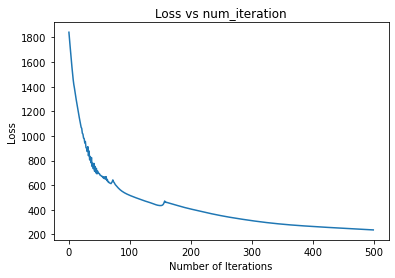

In [43]:
plot_(loss_list, 'Loss')

### b. Acuracy

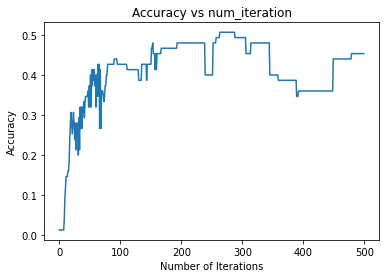

In [44]:
plot_(acc_list, 'Accuracy')